# Milestone 2 
# How much emission are you REALLY responsible for.

In this notebook we focus on exploring the dataset we have selected, and prepare the data for the sory telling in milestone 3.

## Table of contents
1. [Introduction](#introduction)
    1. [Percentage of the emission due to agriculture](#percentage_emissions)
    2. [Part of emission for meat/vegetal products](#world_meat_vegetal)
    3. [Emissions by Countries](#emissions_countries)
2. [Correcting emissions for Belgium and Switzerland](#correcting_emissions)
    1. [Belgium](#belgium_trade)
    2. [Switzerland](#swiss_trade)
    3. [Comparison between Belgium and Switzerland](#comparison_belgium_swiss_trade)


## Introduction <a name="introduction"></a>
we will presented the data from the world point of view including
   - Percentage of the emission due to agriculture in total emission
   - The part of emission in agriculture due to the meat production and all other animal product and the part of emission due to the vegetable source of food
   - The same as the previous point but by country.
    
In the introduction we will show the evolution of these data from 1961 to 2017.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# constants
DATA_PATH = '../data/'
GENERATED_DATA_PATH = '../generated/'

### Percentage of the emission due to agriculture in total emission <a name="percentage_emissions"></a>

Use the Environment_Emissions_by_Sector_E_All_Data_(Normalized) for the world only to show the evolution of the percentage of agriculture emission

### Part of emissions for meat/vegetable <a name="world_meat_vegetal"></a>
Now we will show the evolution of the part of emission due to animal product and the part due to the production of vegetables.

In [3]:
emissions_total_path = DATA_PATH+'Emissions_Agriculture_Agriculture_total_E_All_Data_(Norm).csv'
emissions_total = pd.read_csv(emissions_total_path, encoding='latin-1', engine='python')

In [4]:
print(emissions_total.shape)
emissions_total.head()

(517655, 12)


,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag,Note
0,2,Afghanistan,5058,Enteric Fermentation,7225,Emissions (CH4),1961,1961,gigagrams,240.6831,A,NaN
1,2,Afghanistan,5058,Enteric Fermentation,7225,Emissions (CH4),1962,1962,gigagrams,245.3106,A,NaN
2,2,Afghanistan,5058,Enteric Fermentation,7225,Emissions (CH4),1963,1963,gigagrams,255.8285,A,NaN
3,2,Afghanistan,5058,Enteric Fermentation,7225,Emissions (CH4),1964,1964,gigagrams,259.0650,A,NaN
4,2,Afghanistan,5058,Enteric Fermentation,7225,Emissions (CH4),1965,1965,gigagrams,265.5980,A,NaN


In [5]:
# check for NaN values
emissions_total.columns[emissions_total.isna().any()]

Index(['Note'], dtype='object')

In [6]:
# What kind of emissions are there?
print("We have the following kind of emissions:",emissions_total['Element'].unique())
#print(emissions_total['Element Code'].unique())

# Units are all in Gigagrams
# print(emissions_total['Unit'].unique())

#emissions_total['Country'].unique()

We have the following kind of emissions: ['Emissions (CH4)' 'Emissions (CO2eq)' 'Emissions (CO2eq) from CH4'
 'Emissions (CO2eq) from N2O' 'Emissions (N2O)']


CO2eq means 'Carbon dioxide equivalent'
https://ec.europa.eu/eurostat/statistics-explained/index.php/Glossary:Carbon_dioxide_equivalent

In [7]:
emissions_total.Item.unique()

array(['Enteric Fermentation', 'Manure Management', 'Rice Cultivation',
       'Synthetic Fertilizers', 'Manure applied to Soils',
       'Manure left on Pasture', 'Crop Residues',
       'Burning - Crop residues', 'Burning - Savanna',
       'Agriculture total', 'Agricultural Soils',
       'Cultivation of Organic Soils'], dtype=object)

In [8]:
vegetal_emissions = ['Rice Cultivation', 'Synthetic Fertilizers', 'Manure applied to Soils', 'Crop Residues',
       'Cultivation of Organic Soils', 'Burning - Crop residues']
animal_emissions = ['Enteric Fermentation', 'Manure Management', 'Manure left on Pasture']

In [9]:
# CO2eq is the total (CH4+N20) expressed as Carbon dioxide equivalent

element_code = {'CO2eq': 7231, 'N2O': 7243, 'CH4': 7244}
columns = ['Item', 'Value']

In [10]:
emissions_world = emissions_total[(emissions_total['Area'] == 'World')]

In [11]:
%%capture

emissions_world_CO2eq = emissions_world[emissions_world['Element Code'] == element_code['CO2eq']]
emissions_world_CO2eq = emissions_world_CO2eq[columns].groupby(['Item']).sum().reset_index().set_index('Item')

emissions_world_N2O = emissions_world[emissions_world['Element Code'] == element_code['N2O']]
emissions_world_N2O = emissions_world_N2O[columns].groupby(['Item']).sum().reset_index().set_index('Item')

emissions_world_CH4 = emissions_world[emissions_world['Element Code'] == element_code['CH4']]
emissions_world_CH4 = emissions_world_CH4[columns].groupby(['Item']).sum().reset_index().set_index('Item')

In [12]:
# Drop stats that are sum of the others
emissions_world_CO2eq.drop(['Agricultural Soils', 'Agriculture total'], inplace=True)
emissions_world_CO2eq.sort_values('Value', ascending=False, inplace=True)
print(emissions_world_CO2eq.head())

emissions_world_N2O.drop(['Agricultural Soils', 'Agriculture total'], inplace=True)
emissions_world_N2O.sort_values('Value', ascending=False, inplace=True)

emissions_world_CH4.drop('Agriculture total', inplace=True)
emissions_world_CH4.sort_values('Value', ascending=False, inplace=True)

                               Value
Item                                
Enteric Fermentation    1.065453e+08
Manure left on Pasture  3.920270e+07
Rice Cultivation        2.733425e+07
Synthetic Fertilizers   2.636272e+07
Manure Management       1.875165e+07


In [13]:
# Left join
emissions_plot = emissions_world_CO2eq.join(emissions_world_N2O, lsuffix="CO2eq", rsuffix="N20").join(emissions_world_CH4)\
                    .rename({'Value':'ValueCH4'}, axis=1).reset_index().fillna(0)
emissions_plot.head()

,Item,ValueCO2eq,ValueN20,ValueCH4
0,Enteric Fermentation,1.065453e+08,0.000000e+00,1.065453e+08
1,Manure left on Pasture,3.920270e+07,3.920270e+07,0.000000e+00
2,Rice Cultivation,2.733425e+07,0.000000e+00,2.733425e+07
3,Synthetic Fertilizers,2.636272e+07,2.636272e+07,0.000000e+00
4,Manure Management,1.875165e+07,7.782507e+06,1.096914e+07


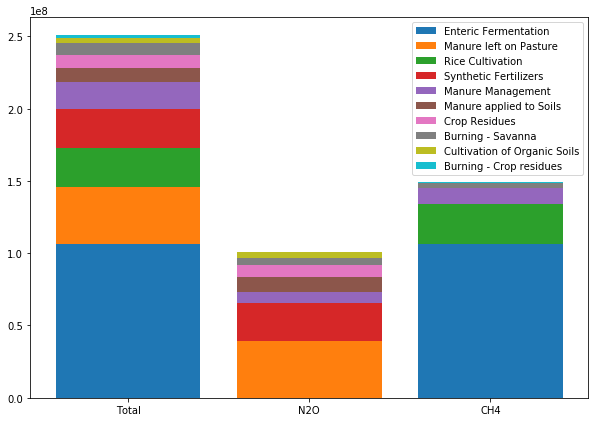

In [14]:
from matplotlib.rcsetup import cycler

fig, ax = plt.subplots(figsize=(10,7))  

items = emissions_plot['Item']
margin_bottom = np.zeros(emissions_plot.shape[1]-1)

ind = ["Total", "N2O", "CH4"]

colors = plt.cm.tab10(np.linspace(0, 1, len(emissions_plot['Item'])))

for num, item in enumerate(items):
    values = list(emissions_plot.loc[num])[1:4]
    plt.bar(ind, values, bottom=margin_bottom, color = colors[num],label=item)
    margin_bottom += values
plt.legend()
plt.show()

#should add the emissions from energy use

### Emission By countries <a name="emissions_countries"></a>

After studying the emissions in their globality we will focus on the emsissions by countries.

In [15]:
# Filter only Emissions (CO2eq)
emissions_total = emissions_total[emissions_total.Element == 'Emissions (CO2eq)']
# We can get rid of all codes + Unit + Element
emissions_total = emissions_total.drop(columns=['Area Code', 'Item Code', 'Element Code', 'Year Code', 'Unit', 'Element'])

In [16]:
# Filter only Emmisions (CO2eq)
print(emissions_total.shape)
emissions_total.head()

(144391, 6)


,Area,Item,Year,Value,Flag,Note
59,Afghanistan,Enteric Fermentation,1961,5054.3459,A,NaN
60,Afghanistan,Enteric Fermentation,1962,5151.5228,A,NaN
61,Afghanistan,Enteric Fermentation,1963,5372.3989,A,NaN
62,Afghanistan,Enteric Fermentation,1964,5440.3650,A,NaN
63,Afghanistan,Enteric Fermentation,1965,5577.5580,A,NaN


In [17]:
# Flags
emissions_total.Flag.value_counts()

A     127183
Fc      9807
EA      7401
Name: Flag, dtype: int64

The flags represent : 
* `A` : Aggregate, may include official, semi-official, estimated or calculated data
* `Fc` : Calculated data
* `EA` : Emissions computed using data from Fertilizer Archive dataset

All these flag are acceptable we can then drop this column

In [18]:
emissions_total = emissions_total.drop(columns=['Flag', 'Note'])

We will check the countries to remove aggragated countries.

In [19]:
emissions_total[emissions_total['Area'] == 'Russian Federation']

,Area,Item,Year,Value
327050,Russian Federation,Enteric Fermentation,1992,95206.1100
327051,Russian Federation,Enteric Fermentation,1993,91153.9093
327052,Russian Federation,Enteric Fermentation,1994,85305.2926
327053,Russian Federation,Enteric Fermentation,1995,75679.1753
327054,Russian Federation,Enteric Fermentation,1996,68794.2746
...,...,...,...,...
328193,Russian Federation,Agricultural Soils,2015,36634.1224
328194,Russian Federation,Agricultural Soils,2016,38897.1667
328195,Russian Federation,Agricultural Soils,2017,40253.8133
328196,Russian Federation,Agricultural Soils,2030,39625.6129


In [20]:
emissions_total.Area.unique()

array(['Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Andorra',
       'Angola', 'Anguilla', 'Antigua and Barbuda', 'Argentina',
       'Armenia', 'Aruba', 'Australia', 'Austria', 'Azerbaijan',
       'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus',
       'Belgium', 'Belgium-Luxembourg', 'Belize', 'Benin', 'Bermuda',
       'Bhutan', 'Bolivia (Plurinational State of)',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei Darussalam', 'Bulgaria',
       'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon',
       'Canada', 'Cayman Islands', 'Central African Republic', 'Chad',
       'Chile', 'China', 'China, Hong Kong SAR', 'China, Macao SAR',
       'China, mainland', 'China, Taiwan Province of', 'Colombia',
       'Comoros', 'Congo', 'Cook Islands', 'Costa Rica', "Côte d'Ivoire",
       'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Czechoslovakia',
       "Democratic People's Republic of Korea",
       'Democratic Re

In [21]:
# Remove aggregation item
agg_item = ['Agriculture total', 'Agricultural Soils']
emissions_total = emissions_total.drop(emissions_total[emissions_total['Item'].isin(agg_item)].index)

# Remove aggregation countries
# We remove China as we have different data for Hong kong, Tawain, Macao and the Mainland
agg_country = ['Belgium-Luxembourg', 'China', 'Yugoslav SFR','World', 'Africa',
       'Eastern Africa', 'Middle Africa', 'Northern Africa',
       'Southern Africa', 'Western Africa', 'Americas',
       'Northern America', 'Central America', 'Caribbean',
       'South America', 'Asia', 'Central Asia', 'Eastern Asia',
       'Southern Asia', 'South-Eastern Asia', 'Western Asia', 'Europe',
       'Eastern Europe', 'Northern Europe', 'Southern Europe',
       'Western Europe', 'Oceania', 'Australia and New Zealand',
       'Melanesia', 'Micronesia', 'Polynesia', 'European Union',
       'Least Developed Countries', 'Land Locked Developing Countries',
       'Small Island Developing States',
       'Low Income Food Deficit Countries',
       'Net Food Importing Developing Countries', 'Annex I countries',
       'Non-Annex I countries', 'OECD']
emissions_total = emissions_total.drop(emissions_total[emissions_total['Area'].isin(agg_country)].index)
emissions_total = emissions_total.rename(columns={'Area':'Country'})

# Keep only past data
emissions_total = emissions_total[emissions_total.Year < 2019]

In [22]:
# Sudan is dived into two country Sudan (former) until 2011 and Sudan from 2012
# We will just merge both
emissions_total.loc[emissions_total[emissions_total['Country'] == 'Sudan (former)'].index,'Country'] = 'Sudan'
# We will do the same for USSR we will consider it as Russian Federation even if the
# Russian federation exists from 1992 and that they do not cover the same regions
emissions_total.loc[emissions_total[emissions_total['Country'] == 'USSR'].index,'Country'] = 'Russian Federation'

In [23]:
# Pivot the table to make element columns
emissions_total = pd.pivot_table(emissions_total, values='Value', index=['Country', 'Year'], columns='Item')
emissions_total.head()

Item              Burning - Crop residues  Burning - Savanna  Crop Residues  \
Country     Year                                                              
Afghanistan 1961                 118.2797                NaN       332.7512   
            1962                 121.7607                NaN       335.2904   
            1963                 121.7607                NaN       312.7451   
            1964                 122.7093                NaN       337.2814   
            1965                 122.3902                NaN       340.9305   

Item              Cultivation of Organic Soils  Enteric Fermentation  \
Country     Year                                                       
Afghanistan 1961                           NaN             5054.3459   
            1962                           NaN             5151.5228   
            1963                           NaN             5372.3989   
            1964                           NaN             5440.3650   
            1965                           NaN             5577.5580   

Item              Manure Management  Manure applied to Soils  \
Country     Year                                               
Afghanistan 1961           367.8310                 390.4421   
            1962           376.4362                 396.0043   
            1963           392.5811                 406.7487   
            1964           399.8526                 415.1598   
            1965           413.3914                 427.7566   

Item              Manure left on Pasture  Rice Cultivation  \
Country     Year                                             
Afghanistan 1961               2368.1734             617.4   
            1962               2326.1498             617.4   
            1963               2390.2709             617.4   
            1964               2422.8848             646.8   
            1965               2482.0286             646.8   

Item              Synthetic Fertilizers  
Country     Year                         
Afghanistan 1961                 6.4546  
            1962                 6.4546  
            1963                 6.4546  
            1964                 6.4546  
            1965                 6.4546

In [24]:
# Here we assume that if there is no data the country just do not produce any emission of that type
emissions_total.fillna(0, inplace=True)

We will now divide the emissions between animal and vegetal emissions

In [25]:
emissions_total['Animal'] = emissions_total[animal_emissions].sum(axis=1)
emissions_total['Vegetal'] = emissions_total[vegetal_emissions].sum(axis=1)
emissions_total = emissions_total[['Animal', 'Vegetal']]
emissions_total.head()

Item                 Animal    Vegetal
Country     Year                      
Afghanistan 1961  7790.3503  1465.3276
            1962  7854.1088  1476.9100
            1963  8155.2509  1465.1091
            1964  8263.1024  1528.4051
            1965  8472.9780  1544.3319

In [26]:
# Create a new column sum
emissions_total['Sum'] = emissions_total.sum(axis=1)
emissions_total.head()

Item                 Animal    Vegetal         Sum
Country     Year                                  
Afghanistan 1961  7790.3503  1465.3276   9255.6779
            1962  7854.1088  1476.9100   9331.0188
            1963  8155.2509  1465.1091   9620.3600
            1964  8263.1024  1528.4051   9791.5075
            1965  8472.9780  1544.3319  10017.3099

In [27]:
# create a new dataframe with relative numbers
relative_emissions_total = pd.DataFrame()
for col in emissions_total.columns:
    new_col = '% '+col
    relative_emissions_total[new_col] = emissions_total[col]/emissions_total['Sum'] * 100
    
relative_emissions_total.head()

% Animal  % Vegetal  % Sum
Country     Year                             
Afghanistan 1961  84.168338  15.831662  100.0
            1962  84.172039  15.827961  100.0
            1963  84.770746  15.229254  100.0
            1964  84.390503  15.609497  100.0
            1965  84.583367  15.416633  100.0

In [28]:
# Save the datasets
emissions_total.to_csv(GENERATED_DATA_PATH+'emissions_total.csv')
relative_emissions_total.to_csv(GENERATED_DATA_PATH+'relative_emissions_total.csv')

#### EDA

We will now look at the descriptive statisitcs of the emission total data frame.

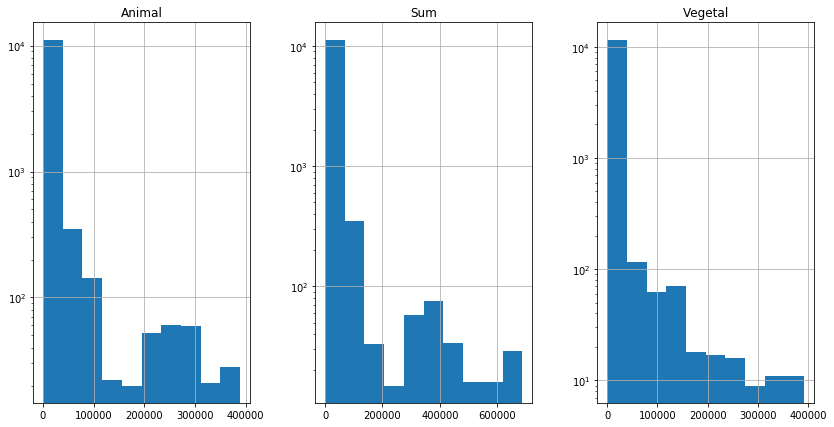

In [29]:
emissions_total.hist(figsize=(14,7), log=True, layout=(1,3))
plt.show()

The distribution seems to follow a exponantial law. Indeed if we look at the higer entry we see that it correspond to the two most populated country in the world (China) for the last years.

In [30]:
emissions_total['Sum'].sort_values(ascending=False).head(10)

Country          Year
China, mainland  2016    687038.3516
                 2015    684334.3034
                 2014    674444.4485
                 2017    674109.1996
                 2013    672499.5226
                 2012    669684.1531
                 2010    668059.8261
                 2011    667251.7956
                 1996    663535.3512
                 2009    658057.4815
Name: Sum, dtype: float64

To balance this bias indroduced by the number of habitans we will divide all the emissions by the number of people to obtain the emission per capita.
The population information are available in the `Population_E_All_Data_(Normalized).csv` dataset.

In [31]:
population = pd.read_csv(DATA_PATH+'Population_E_All_Data_(Normalized).csv',  encoding='latin-1', engine='python')
print(population.shape)
population.head()

(160411, 12)


,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag,Note
0,2,Afghanistan,3010,Population - Est. & Proj.,511,Total Population - Both sexes,1950,1950,1000 persons,7752.118,X,NaN
1,2,Afghanistan,3010,Population - Est. & Proj.,511,Total Population - Both sexes,1951,1951,1000 persons,7840.156,X,NaN
2,2,Afghanistan,3010,Population - Est. & Proj.,511,Total Population - Both sexes,1952,1952,1000 persons,7935.997,X,NaN
3,2,Afghanistan,3010,Population - Est. & Proj.,511,Total Population - Both sexes,1953,1953,1000 persons,8039.694,X,NaN
4,2,Afghanistan,3010,Population - Est. & Proj.,511,Total Population - Both sexes,1954,1954,1000 persons,8151.317,X,NaN


We need to clean the dataset

In [32]:
population = population[population['Element'] == 'Total Population - Both sexes']
population = population.drop(columns = ['Area Code', 'Item Code', 'Item', 'Element Code', 'Element', 'Year Code', 'Unit', 'Flag', 'Note'])
population = population.rename(columns={'Area':'Country', 'Value':'Population'})
# We also apply the transformation from Sudan Fromer to Sudan and fro USSR to Russian Federation
population.loc[population[population['Country'] == 'Sudan (former)'].index,'Country'] = 'Sudan'
population.loc[population[population['Country'] == 'USSR'].index,'Country'] = 'Russian Federation'
# Set Country + Year as index
population = population.set_index(['Country', 'Year'])
print(population.shape)
# we have to multiply the value of popluation by 1000 because the unit was 1000 people
population['Population'] *= 1000
population.head()

(39441, 1)


Population
Country     Year            
Afghanistan 1950   7752118.0
            1951   7840156.0
            1952   7935997.0
            1953   8039694.0
            1954   8151317.0

In [33]:
# We can now make a join with the emission dataset
emissions_total_population = pd.merge(emissions_total, population, left_index=True, right_index=True).sort_index()
emissions_total_population.head()

Animal    Vegetal         Sum  Population
Country     Year                                              
Afghanistan 1961  7790.3503  1465.3276   9255.6779   9169410.0
            1962  7854.1088  1476.9100   9331.0188   9351441.0
            1963  8155.2509  1465.1091   9620.3600   9543205.0
            1964  8263.1024  1528.4051   9791.5075   9744781.0
            1965  8472.9780  1544.3319  10017.3099   9956320.0

Finally we can devide the columns `Animal`, `Vegetal` and `Sum` by the population to obtain the emission per capita. We multiply by $$10^6$$ because the emission dataset is in gigagram so know the emission per capita dataframe is in kilogram of CO2eq 

In [34]:
emissions_per_capita = pd.DataFrame()
for col in ['Animal', 'Vegetal', 'Sum']:
    emissions_per_capita[col] = emissions_total_population[col] / emissions_total_population['Population'] * 1e6
emissions_per_capita.head()

Animal     Vegetal          Sum
Country     Year                                     
Afghanistan 1961  849.602134  159.806094  1009.408228
            1962  839.882196  157.933948   997.816144
            1963  854.561010  153.523800  1008.084810
            1964  847.951575  156.843453  1004.795028
            1965  851.015034  155.110714  1006.125747

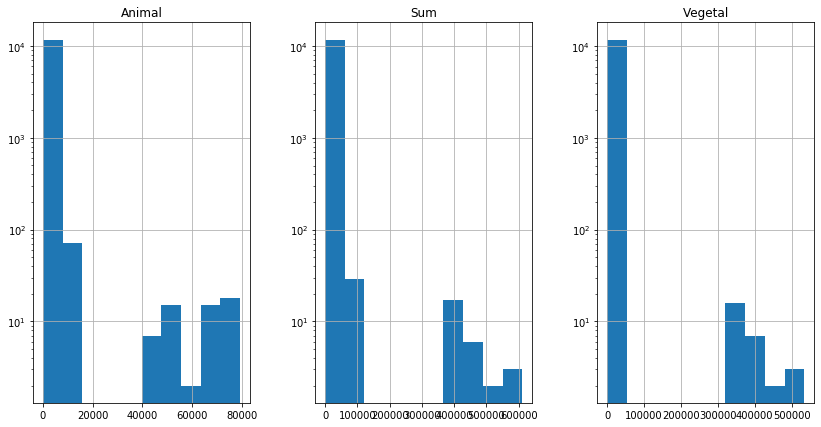

In [35]:
emissions_per_capita.hist(figsize=(14,7), log=True, layout=(1,3))
plt.show()

It seems to have outliers. Let's look at them. 

In [36]:
emissions_per_capita[emissions_per_capita['Animal'] > 40000]

Animal        Vegetal            Sum
Country                     Year                                            
Falkland Islands (Malvinas) 1961  64893.273754     132.126058   65025.399812
                            1962  65012.618147     132.277883   65144.896030
                            1963  67021.763869     133.143670   67154.907539
                            1964  66947.388596     134.786775   67082.175371
                            1965  67267.709336     136.333013   67404.042348
                            1966  67575.801749     138.532556   67714.334305
                            1967  69144.958190     141.170684   69286.128874
                            1968  68678.525482     141.415141   68819.940623
                            1969  69333.083832     142.415170   69475.499002
                            1970  70271.887550     142.921687   70414.809237
                            1971  71866.394697     144.212137   72010.606833
                            1972  71340.878896     142.616249   71483.495146
                            1973  69476.141079     143.931535   69620.072614
                            1974  71083.575884     143.866944   71227.442827
                            1975  73702.417236     145.454545   73847.871781
                            1976  74198.464796     146.003176   74344.467972
                            1977  73767.607885     147.416090   73915.023974
                            1978  74743.619861     172.290443   74915.910304
                            1979  75740.182894     198.224852   75938.407746
                            1980  76314.347357     211.866235   76526.213592
                            1981  75276.543879     238.515710   75515.059588
                            1982  76268.110449     251.109908   76519.220357
                            1983  77077.131993     271.645845   77348.777838
                            1984  77603.629469     292.470206   77896.099675
                            1985  78946.108108     297.351351   79243.459459
                            1986  79171.482480     287.439353   79458.921833
                            1987  76761.423221     245.318352   77006.741573
                            1988  76928.291909     235.060814   77163.352723
                            1989  79316.537066     223.276309   79539.813375
                            1990  76305.802220  534600.655903  610906.458123
                            1991  71976.635967  513604.071740  585580.707707
                            1992  67150.740741  490528.101852  557678.842593
                            1993  64349.253076  465516.827768  529866.080844
                            1994  61742.193386  443545.123483  505287.316869
                            1995  58334.176707  425534.618474  483868.795181
                            1996  53471.379045  408147.072419  461618.451464
                            1997  53331.748979  393446.825102  446778.574081
                            1998  51758.849077  383475.497647  435234.346725
                            1999  49740.161915  372942.731433  422682.893347
                            2000  49455.809129  366361.721992  415817.531120
                            2001  47446.912317  361146.741726  408593.654043
                            2002  47223.515439  359147.234476  406370.749915
                            2003  47091.308759  357933.919513  405025.228272
                            2004  47220.481519  358902.848423  406123.329942
                            2005  47446.916525  360462.180579  407909.097104
                            2006  47464.246762  360546.830266  408011.077028
                            2007  48126.046987  360140.619680  408266.666667
                            2008  48207.366985  360768.656207  408976.023192
                            2009  48455.262256  362506.787796  410962.050051
                            2010  48736.091003  364558.083420  413294.174423
                            2011  49

In [37]:
emissions_total_population.loc['Falkland Islands (Malvinas)'].head()

,Animal,Vegetal,Sum,Population
Year,,,,
1961,137.9631,0.2809,138.2440,2126.0
1962,137.5667,0.2799,137.8466,2116.0
1963,141.3489,0.2808,141.6297,2109.0
1964,139.7192,0.2813,140.0005,2087.0
1965,139.7823,0.2833,140.0656,2078.0


We see that it is only the outliers are constuted by only one country `Falkland Islands (Malvinas)`. Indeed the emission are not so big on absolute but the island is only populated by 2000 people (the data contained in the dataset is correct, we have checked). Furthermore the island (which has the 5th highest Gross Product per Capita) is known for its industry of sheep farming. That explained that the emission coming from animals is the biggest one per capita. For now let us remove that country because even if the data are correct we want to focus on larger country and we do not care about this particular case.

In [38]:
emissions_per_capita = emissions_per_capita.drop(index='Falkland Islands (Malvinas)')

We will now take the mean of the emissions for each country over the years in order to see which are the one who emits the most per capita.

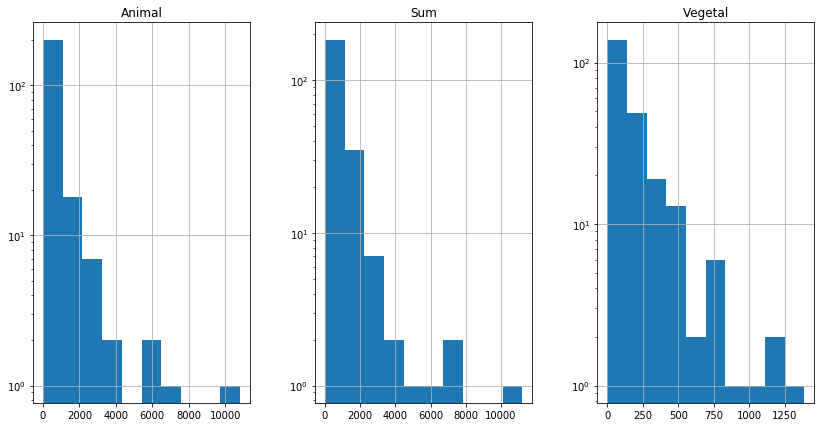

In [39]:
emissions_per_capita = emissions_per_capita.groupby(level=[0]).mean()
emissions_per_capita.hist(figsize=(14,7), log=True, layout=(1,3))
plt.show()

In [40]:
emissions_per_capita['Sum'].sort_values(ascending=False).head(10)

Country
New Zealand    11205.914393
Uruguay         7271.916084
Mongolia        6767.536759
Australia       6433.997722
Ireland         5112.793678
Paraguay        3499.582256
Argentina       3400.526636
Namibia         3083.451317
Somalia         2960.614716
Mauritania      2857.659876
Name: Sum, dtype: float64

In [41]:
emissions_per_capita['Animal'].sort_values(ascending=False).head(10)

Country
New Zealand    10824.516077
Uruguay         6846.297304
Australia       6008.929775
Mongolia        5605.749529
Ireland         3910.083472
Paraguay        3333.476185
Argentina       3159.249555
Namibia         3047.898249
Somalia         2927.568741
Mauritania      2795.033964
Name: Animal, dtype: float64

In [42]:
emissions_per_capita['Vegetal'].sort_values(ascending=False).head(10)

Country
Guyana       1388.612344
Ireland      1202.710206
Mongolia     1161.787230
Belarus      1058.975877
Suriname      964.414557
Cambodia      764.574279
Lithuania     761.597859
Estonia       761.298587
Thailand      731.992301
Denmark       724.873941
Name: Vegetal, dtype: float64

These country are not necessarily the ones we expected. Indeed we do not see China or India.
That's because this dataset focus on emission due to agriculture. Moreover we can see that the top 10 emitters are the same (almost in the same order) if we look at the total emsissions and the emsissions du to animal products. These countries are known for producing a lot of meat. It could be interesting to look at their emission when we have will consider the importations and exportations.

## Correcting emissions for Belgium and Switzerland <a name="correcting_emissions"></a>
Then our main analysis will focus on comparing emission from Belgium and Switzerland for vegetable products and meat products.

The data presented in the introduction do not take into account the importation/exportation of the country.
We will use the `detailed trade matrix` data set to adapt these emission by adding emmission due to the production of imported procuct and removing emission for exportation product.

We will then compare these new data between belgium and Switzerland to figure out which country is responsible for the most emission.

First because the trade data set is huge we will only select rows concerning Belgium and then export the dataset to pandas to create a new csv file containing the rows we want.

In [43]:
import pyspark
import pyspark.sql
from pyspark.sql import *
from pyspark.sql.functions import *

conf = pyspark.SparkConf().setMaster("local[*]").setAll([
                                   ('spark.executor.memory', '12g'),  # find
                                   ('spark.driver.memory','4g'), # your
                                   ('spark.driver.maxResultSize', '2G') # setup
                                  ])
# create the session
spark = SparkSession.builder.config(conf=conf).getOrCreate()

# create the context
sc = spark.sparkContext

# FIX for Spark 2.x
locale = sc._jvm.java.util.Locale
locale.setDefault(locale.forLanguageTag("en-US"))

In [44]:
trades = spark.read.csv(DATA_PATH+'Trade_DetailedTradeMatrix_E_All_Data_(Normalized).csv', header =True)

In [45]:
trades.printSchema()

root
 |-- Reporter Country Code: string (nullable = true)
 |-- Reporter Countries: string (nullable = true)
 |-- Partner Country Code: string (nullable = true)
 |-- Partner Countries: string (nullable = true)
 |-- Item Code: string (nullable = true)
 |-- Item: string (nullable = true)
 |-- Element Code: string (nullable = true)
 |-- Element: string (nullable = true)
 |-- Year Code: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- Unit: string (nullable = true)
 |-- Value: string (nullable = true)
 |-- Flag: string (nullable = true)



In [46]:
trades = trades.withColumnRenamed('Reporter Countries', 'Countries')

### Belgium <a name="belgium_trade"></a>

We will first study the trade of belgium

In [47]:
trades.registerTempTable("Trades")

query = """
SELECT *
FROM Trades
WHERE Countries = 'Belgium'
"""

belgium_trade = spark.sql(query)
belgium_trade.show(5)

+---------------------+---------+--------------------+-----------------+---------+---------------+------------+---------------+---------+----+--------+--------+----+
|Reporter Country Code|Countries|Partner Country Code|Partner Countries|Item Code|           Item|Element Code|        Element|Year Code|Year|    Unit|   Value|Flag|
+---------------------+---------+--------------------+-----------------+---------+---------------+------------+---------------+---------+----+--------+--------+----+
|                  255|  Belgium|                   2|      Afghanistan|      231|Almonds shelled|        5610|Import Quantity|     2015|2015|  tonnes|0.000000|null|
|                  255|  Belgium|                   2|      Afghanistan|      231|Almonds shelled|        5610|Import Quantity|     2016|2016|  tonnes|1.000000|null|
|                  255|  Belgium|                   2|      Afghanistan|      231|Almonds shelled|        5610|Import Quantity|     2017|2017|  tonnes|1.000000|null|
|   

In [48]:
belgium_trade_df = belgium_trade.toPandas()

In [49]:
belgium_trade_df.to_csv(GENERATED_DATA_PATH+'trade_belgium.csv')

From now we can begin with this cell.

In [50]:
belgium_trade_df = pd.read_csv(GENERATED_DATA_PATH+'trade_belgium.csv', index_col=0)

In [51]:
belgium_trade_df.head()

,Reporter Country Code,Countries,Partner Country Code,Partner Countries,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
0,255,Belgium,2,Afghanistan,231,Almonds shelled,5610,Import Quantity,2015,2015,tonnes,0.0,NaN
1,255,Belgium,2,Afghanistan,231,Almonds shelled,5610,Import Quantity,2016,2016,tonnes,1.0,NaN
2,255,Belgium,2,Afghanistan,231,Almonds shelled,5610,Import Quantity,2017,2017,tonnes,1.0,NaN
3,255,Belgium,2,Afghanistan,231,Almonds shelled,5622,Import Value,2015,2015,1000 US$,0.0,NaN
4,255,Belgium,2,Afghanistan,231,Almonds shelled,5622,Import Value,2016,2016,1000 US$,4.0,NaN


Get rid of useless columns and rename `Partner Countries`

In [52]:
belgium_trade_df = belgium_trade_df.drop(columns=['Reporter Country Code', 'Countries', 'Partner Country Code', 'Item Code', 'Element Code', 'Year Code', 'Unit', 'Flag'])
belgium_trade_df = belgium_trade_df.rename(columns={'Partner Countries': 'Country'})

In [53]:
belgium_trade_df.head()

,Country,Item,Element,Year,Value
0,Afghanistan,Almonds shelled,Import Quantity,2015,0.0
1,Afghanistan,Almonds shelled,Import Quantity,2016,1.0
2,Afghanistan,Almonds shelled,Import Quantity,2017,1.0
3,Afghanistan,Almonds shelled,Import Value,2015,0.0
4,Afghanistan,Almonds shelled,Import Value,2016,4.0


We will separate this dataset into 2 dataset : one for the trading of meat and animal product and the other for the vegetable products. The lists of animal items and vegetable item are in the `anim_items_trade.txt` and `veg_items_trade.txt` and have been done by hand.

In [54]:
animal_item = np.loadtxt(DATA_PATH+'anim_items_trade.txt', delimiter = '  ', dtype='str')

In [55]:
belgium_animal_trade = belgium_trade_df[belgium_trade_df.Item.isin(animal_item)]
belgium_animal_trade.head()

,Country,Item,Element,Year,Value
6,Afghanistan,"Animals, live, non-food",Export Value,2008,14.0
7,Afghanistan,"Animals, live, non-food",Export Value,2009,9.0
8,Afghanistan,"Animals, live, non-food",Export Value,2017,34.0
17,Afghanistan,Bacon and ham,Export Quantity,2005,0.0
18,Afghanistan,Bacon and ham,Export Quantity,2015,5.0


In [56]:
belgium_animal_trade = belgium_animal_trade.drop(columns='Item')

Get only the export quantity and import quantity

In [57]:
belgium_animal_trade.Element.unique()

array(['Export Value', 'Export Quantity', 'Import Quantity',
       'Import Value'], dtype=object)

In [58]:
belgium_animal_trade = belgium_animal_trade[belgium_animal_trade.Element.isin(['Export Quantity', 'Import Quantity'])]

In [59]:
# Pivot the table
belgium_animal_trade = pd.pivot_table(belgium_animal_trade, values='Value', index=['Country', 'Year'], columns='Element')
belgium_animal_trade.head()

Element           Export Quantity  Import Quantity
Country     Year                                  
Afghanistan 2003        22.000000              NaN
            2004         0.000000              NaN
            2005         1.166667              NaN
            2006        14.000000              NaN
            2007        25.000000              NaN

In [60]:
belgium_animal_trade.isnull().sum()[belgium_animal_trade.isnull().sum() != 0]

Element
Export Quantity      22
Import Quantity    1702
dtype: int64

We will fill the NaN value with 0 and consider the Belgium dif no import/export animal product the corresponding year from/to the country

In [61]:
belgium_animal_trade = belgium_animal_trade.fillna(value=0)

We will compute the net importation/exportation quantity between a country and belgium

In [62]:
belgium_animal_trade['Net Quantity'] = belgium_animal_trade['Import Quantity'] - belgium_animal_trade['Export Quantity']

We have information about ony the 21st century

In [63]:
belgium_animal_trade.index.levels[1]

Int64Index([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
            2011, 2012, 2013, 2014, 2015, 2016, 2017],
           dtype='int64', name='Year')

But for some countries we do not have information about all year. We will just fill these years with 0's and consider that belgium didn't trade with these countries these years.

In [64]:
new_data = pd.DataFrame()
for col in belgium_animal_trade.columns:
    new_data[col] = belgium_animal_trade[col].unstack().fillna(value=0).stack()
belgium_animal_trade = new_data

In [65]:
belgium_animal_trade.head()

Export Quantity  Import Quantity  Net Quantity
Country     Year                                                
Afghanistan 2000              0.0              0.0           0.0
            2001              0.0              0.0           0.0
            2002              0.0              0.0           0.0
            2003             22.0              0.0         -22.0
            2004              0.0              0.0           0.0

We will do the same with the vegetable products

In [66]:
vegetable_item = np.loadtxt(DATA_PATH+'veg_items_trade.txt', delimiter = '  ', dtype='str')

def clean_trade_data(country_trade, item_list):
    # Keep animal or vegetable items
    trade = country_trade[country_trade.Item.isin(item_list)]
    trade = trade.drop(columns='Item')
    trade = trade[trade.Element.isin(['Export Quantity', 'Import Quantity'])]
    # Keep data from 2000 and after
    trade = trade[trade.Year >= 2000]
    # Pivot the table
    trade = pd.pivot_table(trade, values='Value', index=['Country', 'Year'], columns='Element')
    # Fill NaN
    trade.fillna(value=0, inplace=True)
    # Compute the Net Quantity
    trade['Net Quantity'] = trade['Import Quantity'] - trade['Export Quantity']
    # Fill the missing years with 0's
    new_data = pd.DataFrame()
    for col in trade.columns:
        new_data[col] = trade[col].unstack().fillna(value=0).stack()
    trade = new_data
    return trade

belgium_vegetable_trade = clean_trade_data(belgium_trade_df, vegetable_item)
belgium_vegetable_trade.head()

Export Quantity  Import Quantity  Net Quantity
Country     Year                                                
Afghanistan 2000          8154.50              0.0      -8154.50
            2001          1014.00              0.0      -1014.00
            2002           151.40              0.0       -151.40
            2003           373.00              0.0       -373.00
            2004           710.25              0.0       -710.25

We will now look at the evolution of the total net quantity traded by belgium from 2000 to 2017 for animal products and vegetable products.

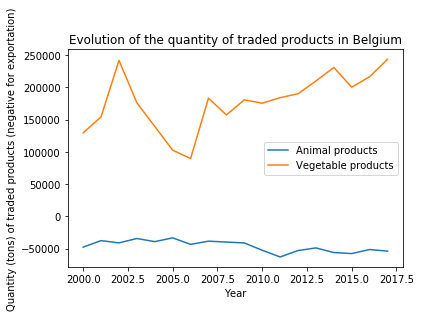

In [67]:
total_animal_product = []
total_vegetable_product = []
for year in range(2000, 2018):
    total_animal_product.append(belgium_animal_trade.xs(year, level=1)['Net Quantity'].sum())
    total_vegetable_product.append(belgium_vegetable_trade.xs(year, level=1)['Net Quantity'].sum())

plt.plot(range(2000,2018), total_animal_product, label='Animal products')
plt.plot(range(2000,2018), total_vegetable_product, label='Vegetable products')
plt.title("Evolution of the quantity of traded products in Belgium")
plt.ylabel("Quantity (tons) of traded products (negative for exportation)")
plt.xlabel("Year")
plt.legend()
plt.show()

We can see that Belgium export more animal product than it import and that the quantity of exported animal product is relatively constant while Belgium imports much more vegetable products (one part of these vegetable product are used to feed the livestock). Moreover the importation of vegetable product has grown in the past few years.

### Switzerland <a name="swiss_trade"></a>

We will do the same job for switzerland
We first neeed to extract data related to switzerlad in the detailed trade matrix

In [68]:
trades.registerTempTable("Trades")

query = """
SELECT *
FROM Trades
WHERE Countries = 'Switzerland'
"""

swiss_trade = spark.sql(query)

In [69]:
swiss_trade_df = swiss_trade.toPandas()
swiss_trade_df.to_csv(GENERATED_DATA_PATH+'trade_switzerland.csv')

In [70]:
swiss_trade_df = pd.read_csv(GENERATED_DATA_PATH+'trade_switzerland.csv', index_col=0)
swiss_trade_df = swiss_trade_df.drop(columns=['Reporter Country Code', 'Countries', 'Partner Country Code', 'Item Code', 'Element Code', 'Year Code', 'Unit', 'Flag'])
swiss_trade_df = swiss_trade_df.rename(columns={'Partner Countries': 'Country'})

In [71]:
swiss_animal_trade = clean_trade_data(swiss_trade_df, animal_item)
swiss_vegetable_trade = clean_trade_data(swiss_trade_df, vegetable_item)

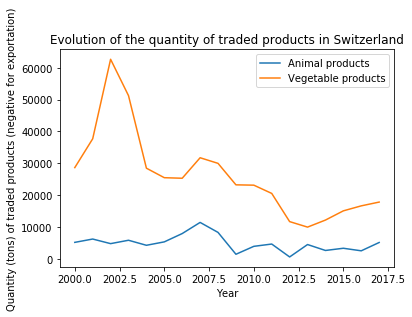

In [72]:
total_animal_product = []
total_vegetable_product = []
for year in range(2000, 2018):
    total_animal_product.append(swiss_animal_trade.xs(year, level=1)['Net Quantity'].sum())
    total_vegetable_product.append(swiss_vegetable_trade.xs(year, level=1)['Net Quantity'].sum())

plt.plot(range(2000,2018), total_animal_product, label='Animal products')
plt.plot(range(2000,2018), total_vegetable_product, label='Vegetable products')
plt.title("Evolution of the quantity of traded products in Switzerland")
plt.ylabel("Quantity (tons) of traded products (negative for exportation)")
plt.xlabel("Year")
plt.legend()
plt.show()

We can see that switzerland import both animal and vegetable products. The importation of meat product is constant while the importation of vegetable product has decrease from 2002.

### Comparison between belgium and switzerland <a name="comparison_belgium_swiss_trade"></a>
The first comparison is made based on the quantity of importation for animal and vegetable products.

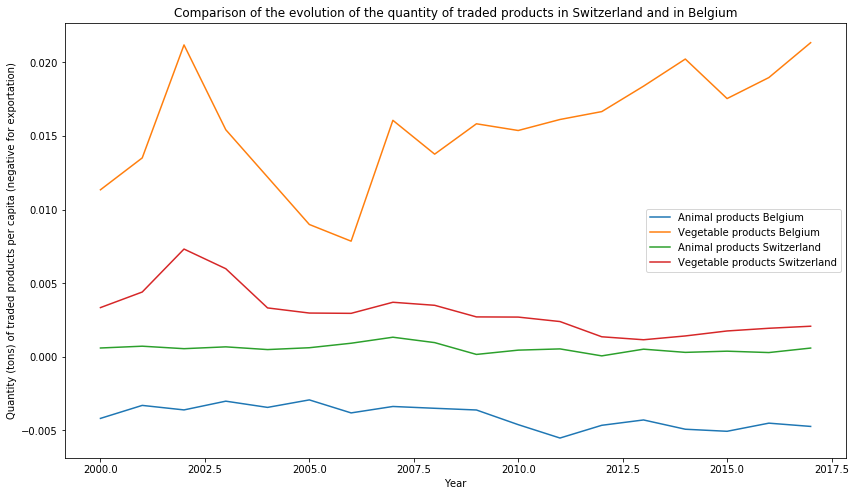

In [73]:
total_animal_product_belgium = []
total_vegetable_product_belgium = []
total_animal_product_switzerland = []
total_vegetable_product_switzerland = []

people_swiss = 8556000
people_belgium = 11400000

for year in range(2000, 2018):
    total_animal_product_belgium.append(belgium_animal_trade.xs(year, level=1)['Net Quantity'].sum()/people_belgium)
    total_vegetable_product_belgium.append(belgium_vegetable_trade.xs(year, level=1)['Net Quantity'].sum()/people_belgium)
    total_animal_product_switzerland.append(swiss_animal_trade.xs(year, level=1)['Net Quantity'].sum()/people_swiss)
    total_vegetable_product_switzerland.append(swiss_vegetable_trade.xs(year, level=1)['Net Quantity'].sum()/people_swiss)

plt.figure(figsize=(14,8))
plt.plot(range(2000,2018), total_animal_product_belgium, label='Animal products Belgium')
plt.plot(range(2000,2018), total_vegetable_product_belgium, label='Vegetable products Belgium')
plt.plot(range(2000,2018), total_animal_product_switzerland, label='Animal products Switzerland')
plt.plot(range(2000,2018), total_vegetable_product_switzerland, label='Vegetable products Switzerland')
plt.title("Comparison of the evolution of the quantity of traded products in Switzerland and in Belgium")
plt.ylabel("Quantity (tons) of traded products per capita (negative for exportation)")
plt.xlabel("Year")
plt.legend()
plt.show()

We can see that per capita, Belgium export more animal products but import much more vegetable product than Switzerland.

### Adding emissions <a name="adding_emissions"></a>
We will first compare direct emissions of the two countries. Then we will add the emission from the country where Belgium and Switzerland import their food. 

We will now join the emission dataframe with the dataframes created in the previous section

In [74]:
swiss_emission = emissions_total.loc['Switzerland']
swiss_emission = swiss_emission[swiss_emission.index >= 2000]
swiss_emission = swiss_emission[swiss_emission.index < 2018]

belgium_emission = emissions_total.loc['Belgium']
belgium_emission = belgium_emission[belgium_emission.index >= 2000]
belgium_emission = belgium_emission[belgium_emission.index < 2018]

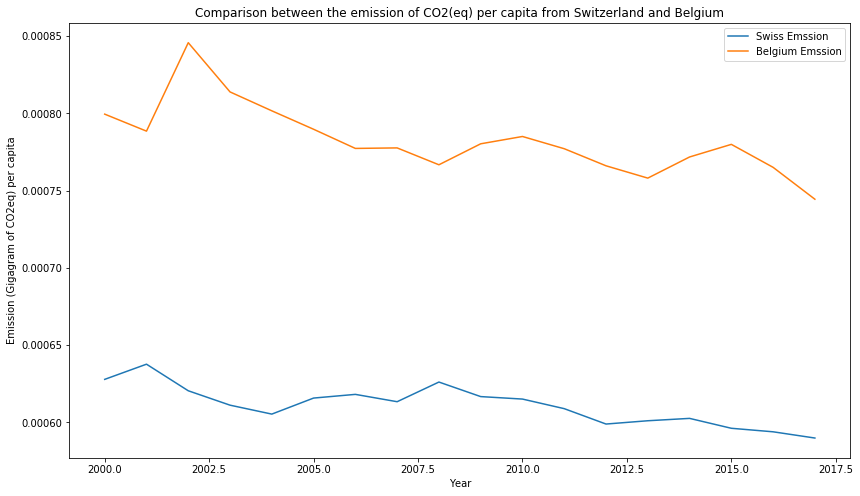

In [75]:
plt.figure(figsize=(14,8))
plt.plot(swiss_emission.index, swiss_emission.Sum/people_swiss, label='Swiss Emssion')
plt.plot(belgium_emission.index, belgium_emission.Sum/people_belgium, label='Belgium Emssion')
plt.title("Comparison between the emission of CO2(eq) per capita from Switzerland and Belgium")
plt.ylabel("Emission (Gigagram of CO2eq) per capita")
plt.xlabel("Year")
plt.legend()
plt.show()

We see that Belgium emits much more CO2eq per capita than Switerland. But it seems that both country try to reduce their emissions of CO2 eq.

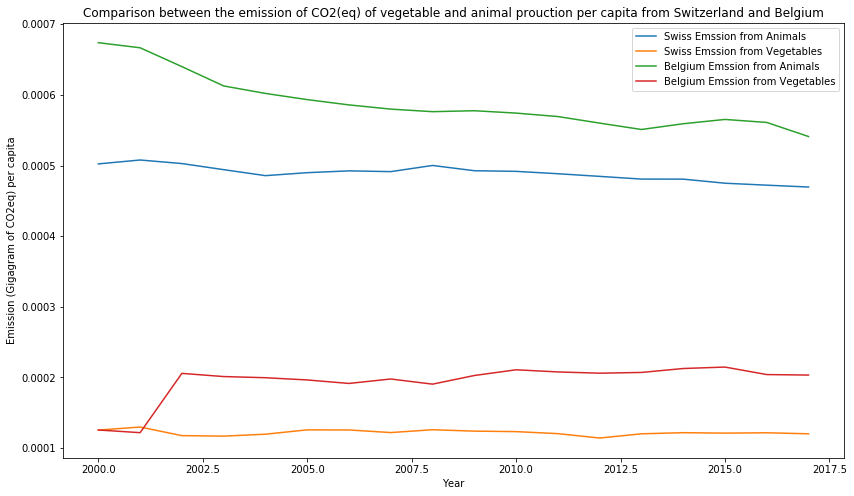

In [76]:
plt.figure(figsize=(14,8))
plt.plot(swiss_emission.index, swiss_emission.Animal/people_swiss, label='Swiss Emssion from Animals')
plt.plot(swiss_emission.index, swiss_emission.Vegetal/people_swiss, label='Swiss Emssion from Vegetables')
plt.plot(belgium_emission.index, belgium_emission.Animal/people_belgium, label='Belgium Emssion from Animals')
plt.plot(belgium_emission.index, belgium_emission.Vegetal/people_belgium, label='Belgium Emssion from Vegetables')
plt.title("Comparison between the emission of CO2(eq) of vegetable and animal prouction per capita from Switzerland and Belgium")
plt.ylabel("Emission (Gigagram of CO2eq) per capita")
plt.xlabel("Year")
plt.legend()
plt.show()

As seen before the majority of the emission is due to the production of animal product. Moreover the decreasing of the emission in total is due more by the reduction of emission of CO2eq from the production of animal products.

We now add the emission in the previously constructed datasets

In [77]:
def add_emissions(trade, emissions_total, local_emission):
    trade = pd.merge(trade, emissions_total['Animal'], left_index=True, right_index=True)
    trade = trade.rename(columns={'Animal':'Emission'})
    trade = pd.merge(trade, local_emission['Animal'], left_index=True, right_index=True)
    trade = trade.rename(columns={'Animal':'Local Emission'})
    return trade


belgium_animal_trade = add_emissions(belgium_animal_trade, emissions_total, belgium_emission)
belgium_vegetable_trade = add_emissions(belgium_vegetable_trade, emissions_total, belgium_emission)
swiss_animal_trade = add_emissions(swiss_animal_trade, emissions_total, swiss_emission)
swiss_vegetable_trade = add_emissions(swiss_vegetable_trade, emissions_total, swiss_emission)

In [78]:
belgium_animal_trade.to_csv(GENERATED_DATA_PATH+'belgium_animal_trade.csv')
belgium_vegetable_trade.to_csv(GENERATED_DATA_PATH+'belgium_vegetable_trade.csv')
swiss_animal_trade.to_csv(GENERATED_DATA_PATH+'swiss_animal_trade.csv')
swiss_vegetable_trade.to_csv(GENERATED_DATA_PATH+'swiss_vegetable_trade.csv')